# Cluster
### Objectives
- Fit and evaluate a cluster model to group similar data
- Understand the profile for each cluster
### Inputs
- outputs/datasets/collection/house-price-2021.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.
### Outputs
- Cluster Pipeline
- Train Set
- Most important features to define a cluster plot
- Clusters Profile Description
- Cluster Silhouette
---
## Change working directory

We need to change the working directory from its current folder to its parent folder

- We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housing-market-analysis/jupyter_notebooks'

We want to make the parent of the parent of current directory the new current directory

    - os.path.dirname() gets the parent directory
    - os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/housing-market-analysis'

## **Load Data**

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house-price-2021.csv")
      .drop(['WoodDeckSF', 'SalePrice', 'EnclosedPorch'], axis=1)
      )
print(df.shape)
df.head(3)

(292, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,1091,898.0,3.0,Mn,932,GLQ,133,586,Fin,2002.0,...,Gd,11367,90.0,210.0,60,5,8,1065,2002,2002
1,988,517.0,3.0,No,399,Rec,484,240,Unf,1940.0,...,TA,9144,66.0,0.0,0,5,5,883,1940,1982
2,1040,0.0,3.0,Mn,532,LwQ,364,484,Unf,1977.0,...,Gd,8800,61.0,0.0,0,7,5,1040,1977,2008


## Cluster Pipeline with all data
### ML Cluster Pipeline

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import MeanMedianImputer
from feature_engine.transformation import LogTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Define numerical features
numerical_features = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                    'BsmtFinSF1', 'BsmtUnfSF','LotArea',
                    'GarageArea',  'GarageYrBlt', 'OpenPorchSF',
                    'LotFrontage', 'MasVnrArea',  'OverallCond',	
                    'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']  # List of numerical features

# Define categorical features
categorical_features = ['KitchenQual','BsmtExposure','BsmtFinType1','GarageFinish']  # List of categorical features

def PipelineCluster():
    # Define ordinal encoder for categorical features
    ordinal_encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_features)

    # Define correlated feature selection
    correlated_selection = SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")

    # Define imputer for missing values
    imputer = SimpleImputer(strategy='median')

    # Define scaler for numerical features
    scaler = StandardScaler()

    # Define PCA for dimensionality reduction
    pca = PCA(n_components=50, random_state=101)

    # Define KMeans clustering
    kmeans = KMeans(n_clusters=50, random_state=101)

    # Define pipeline steps
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", ordinal_encoder),
        ("SmartCorrelatedSelection", correlated_selection),
        ("imputer", imputer),
        ("scaler", scaler),
        ("PCA", pca),
        ("model", kmeans)
    ])
    
    return pipeline_base

### Principal Component Analysis (PCA)

In [6]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))


(292, 15) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 15 components explain 100.0% of the data 



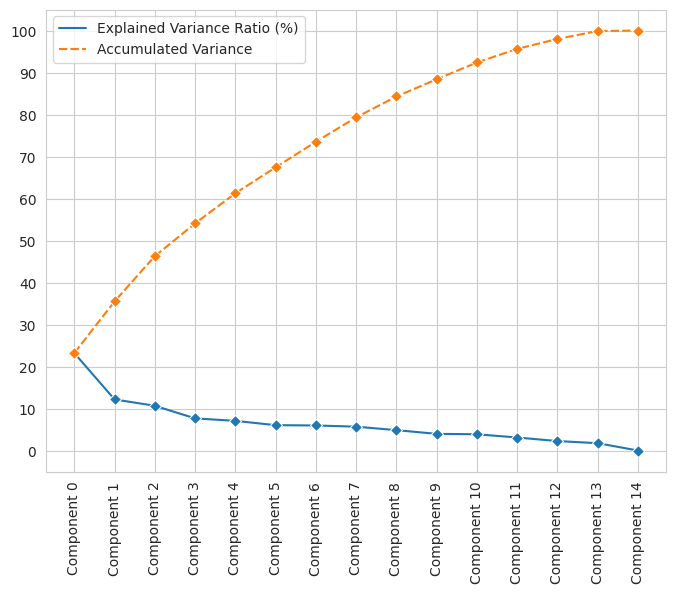

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 15


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="D")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 8 components explain 79.34% of the data 



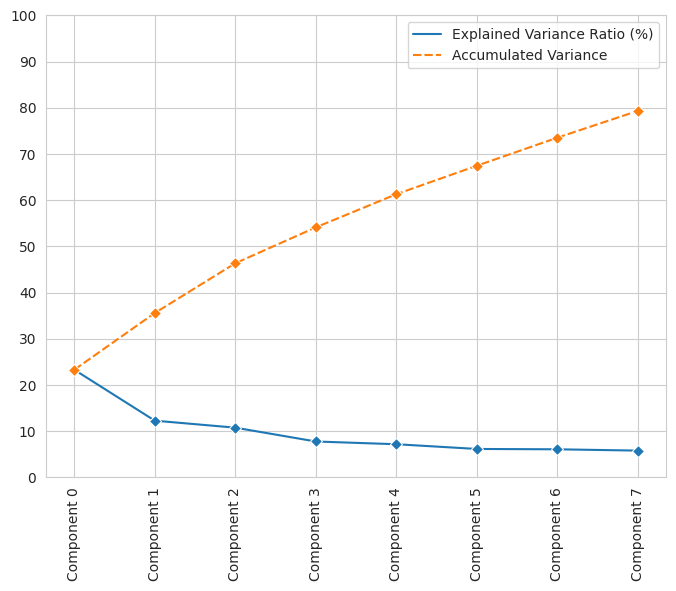

In [8]:
pca_components_analysis(df_pca=df_pca, n_components=8)

In [9]:
def PipelineCluster():
    # Define ordinal encoder for categorical features
    ordinal_encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_features)

    # Define correlated feature selection
    correlated_selection = SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")

    # Define imputer for missing values
    imputer = SimpleImputer(strategy='median')

    # Define scaler for numerical features
    scaler = StandardScaler()

    # Define PCA for dimensionality reduction
    pca = PCA(n_components=9, random_state=101)

    # Define KMeans clustering
    kmeans = KMeans(n_clusters=50, random_state=101)

    # Define pipeline steps
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", ordinal_encoder),
        ("SmartCorrelatedSelection", correlated_selection),
        ("imputer", imputer),
        ("scaler", scaler),
        ("PCA", pca),
        ("model", kmeans)
    ])
    
    return pipeline_base

### Elbow Method and Silhouette Score

In [10]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(292, 9) 
 <class 'numpy.ndarray'>


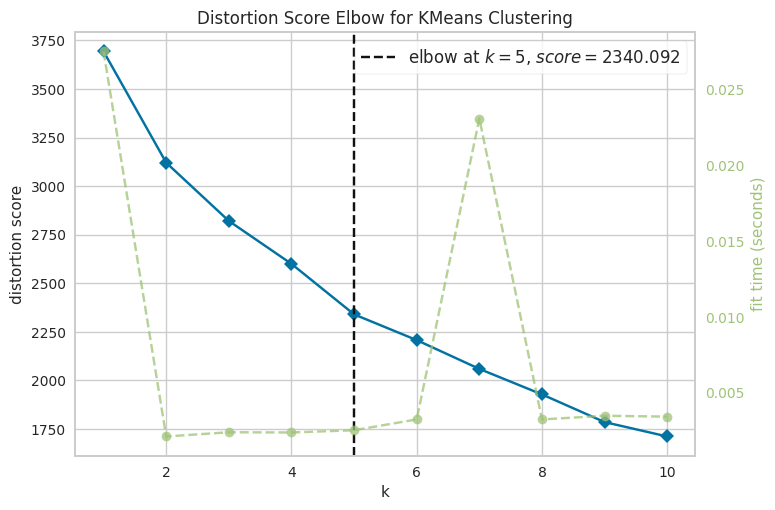

In [11]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# Available font families
plt.rcParams['font.family'] = 'DejaVu Sans'

visualizer = KElbowVisualizer(KMeans(random_state=101), k=(1,11)) # 11 is not included, it will plot until 10
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


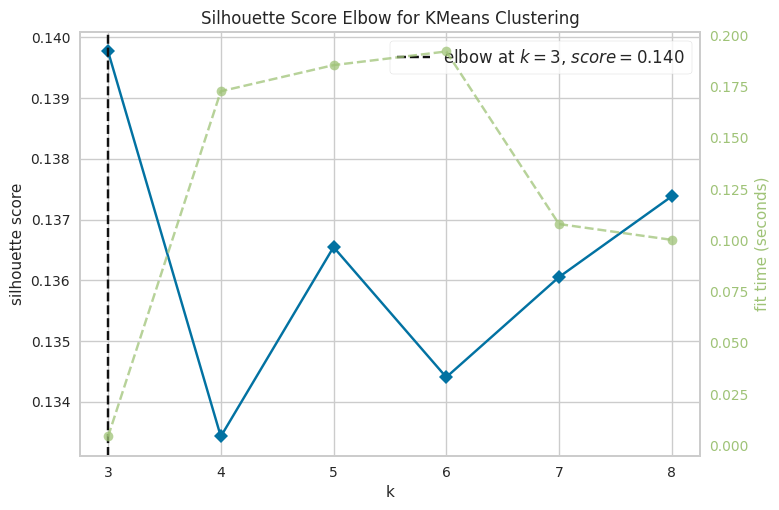



=== Silhouette plot for 3 Clusters ===


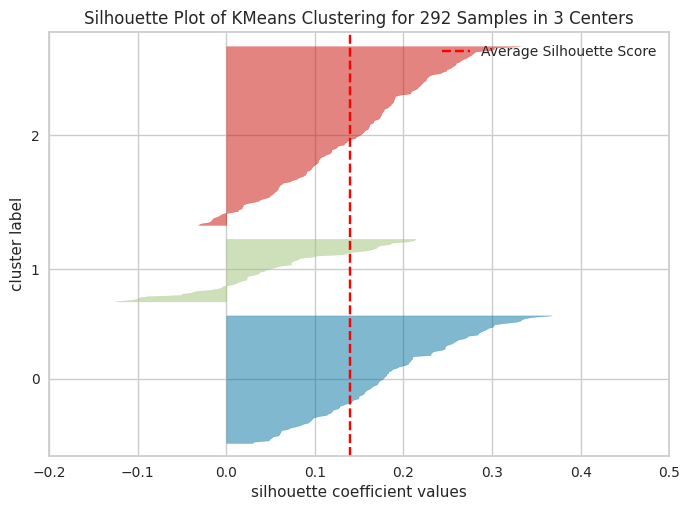



=== Silhouette plot for 4 Clusters ===


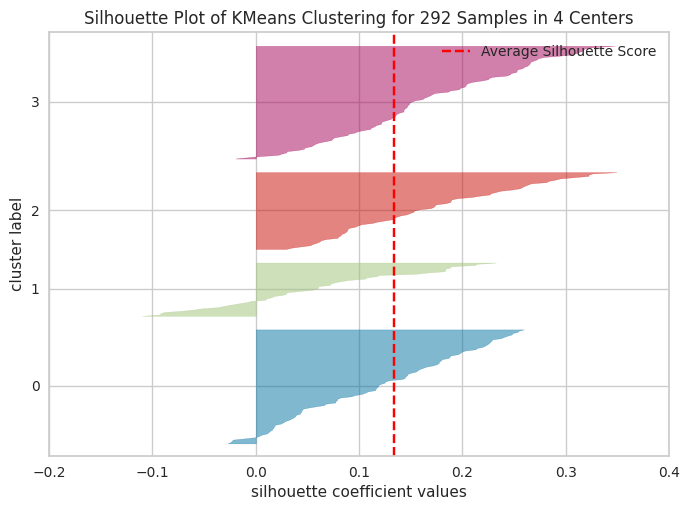



=== Silhouette plot for 5 Clusters ===


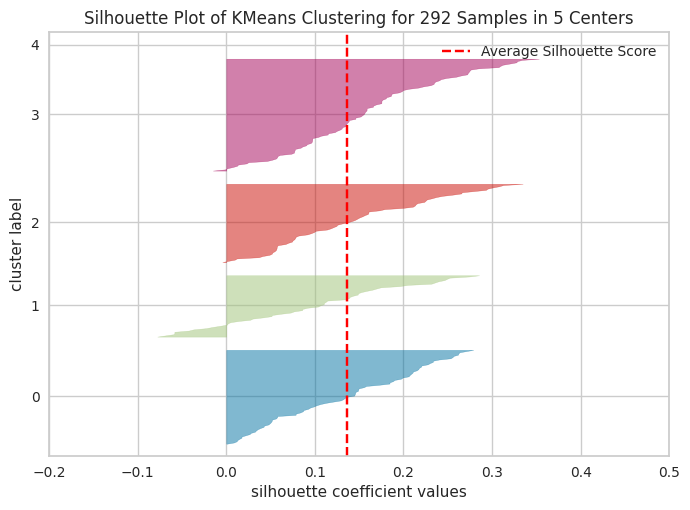



=== Silhouette plot for 6 Clusters ===


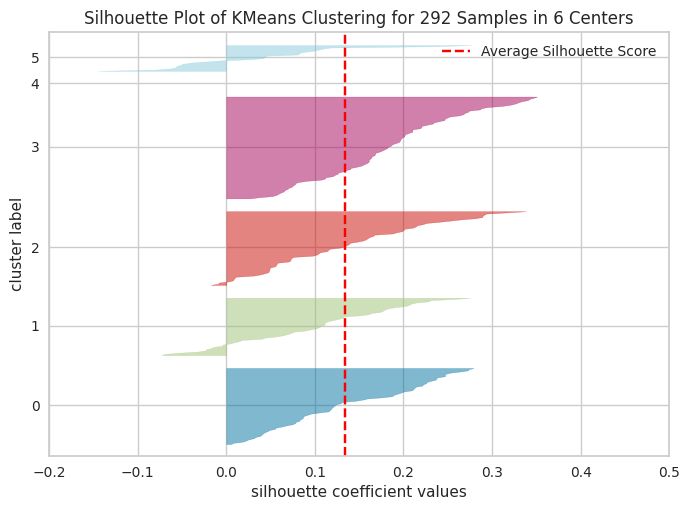



=== Silhouette plot for 7 Clusters ===


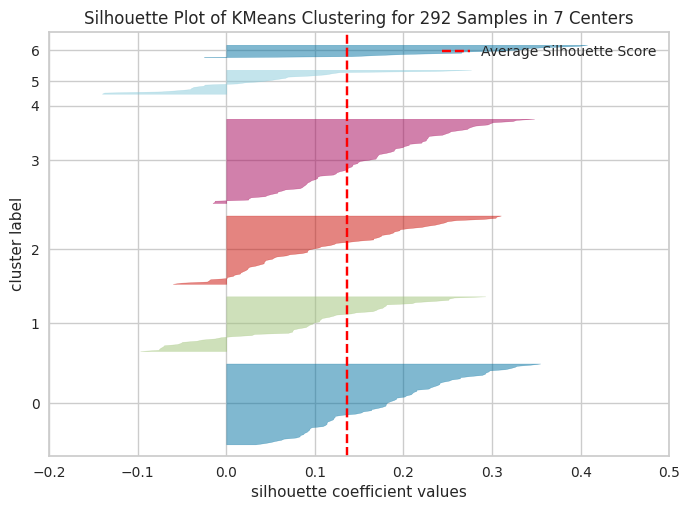



=== Silhouette plot for 8 Clusters ===


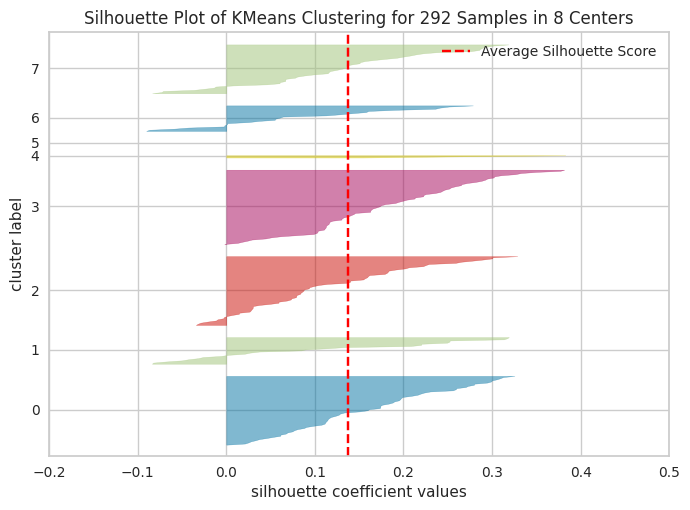

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer

# 9 is not included, it will stop at 8
n_cluster_start, n_cluster_stop = 3, 9

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=101), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=101),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

In [13]:
def PipelineCluster():
    # Define ordinal encoder for categorical features
    ordinal_encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_features)

    # Define correlated feature selection
    correlated_selection = SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")

    # Define imputer for missing values
    imputer = SimpleImputer(strategy='median')

    # Define scaler for numerical features
    scaler = StandardScaler()

    # Define PCA for dimensionality reduction
    pca = PCA(n_components=8, random_state=101)

    # Define KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=101)

    # Define pipeline steps
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", ordinal_encoder),
        ("SmartCorrelatedSelection", correlated_selection),
        ("scaler", scaler),
        ("imputer", imputer),
        ("PCA", pca),
        ("model", kmeans)
    ])
    
    return pipeline_base

### Fit Cluster Pipeline
Quick recap of our data for training cluster pipeline

In [14]:
X = df.copy()
print(X.shape)
X.head()

(292, 21)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
0,1091,898.0,3.0,Mn,932,GLQ,133,586,Fin,2002.0,...,Gd,11367,90.0,210.0,60,5,8,1065,2002,2002
1,988,517.0,3.0,No,399,Rec,484,240,Unf,1940.0,...,TA,9144,66.0,0.0,0,5,5,883,1940,1982
2,1040,0.0,3.0,Mn,532,LwQ,364,484,Unf,1977.0,...,Gd,8800,61.0,0.0,0,7,5,1040,1977,2008
3,1572,1096.0,3.0,Av,1016,GLQ,556,726,Fin,2003.0,...,Ex,13688,110.0,664.0,0,5,9,1572,2003,2004
4,2020,0.0,3.0,No,1436,GLQ,570,900,Fin,2009.0,...,Ex,12220,94.0,305.0,54,5,10,2006,2009,2009


Fit Cluster pipeline

In [15]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual', 'BsmtExposure',
                                           'BsmtFinType1', 'GarageFinish'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('PCA', PCA(n_components=8, random_state=101)),
                ('model', KMeans(n_clusters=3, random_state=101))])

### Add cluster predictions to dataset
We add a column *Clusters* (with the cluster pipeline predictions) to the dataset

In [16]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(5)

(292, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,Clusters
0,1091,898.0,3.0,Mn,932,GLQ,133,586,Fin,2002.0,...,11367,90.0,210.0,60,5,8,1065,2002,2002,1
1,988,517.0,3.0,No,399,Rec,484,240,Unf,1940.0,...,9144,66.0,0.0,0,5,5,883,1940,1982,0
2,1040,0.0,3.0,Mn,532,LwQ,364,484,Unf,1977.0,...,8800,61.0,0.0,0,7,5,1040,1977,2008,0
3,1572,1096.0,3.0,Av,1016,GLQ,556,726,Fin,2003.0,...,13688,110.0,664.0,0,5,9,1572,2003,2004,1
4,2020,0.0,3.0,No,1436,GLQ,570,900,Fin,2009.0,...,12220,94.0,305.0,54,5,10,2006,2009,2009,1


* Clusters frequencies 
   Clusters
0      0.48
2      0.36
1      0.16 




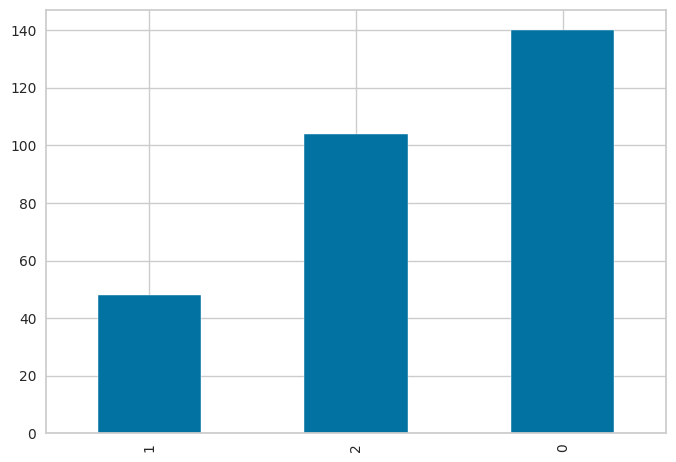

In [17]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

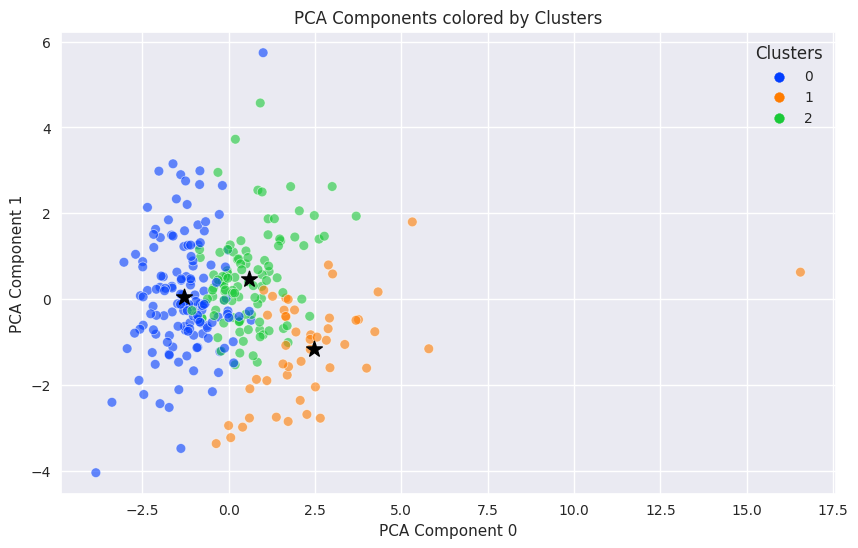

In [18]:
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='bright', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="*", s=140, linewidths=1, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

We save the cluster predictions from this pipeline to use in the future. We will get back to that in a later stage.

In [19]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0      1
1      0
2      0
3      1
4      1
      ..
287    0
288    1
289    1
290    1
291    2
Name: Clusters, Length: 292, dtype: int32

### Fit a classifier, where the target is cluster predictions and features remaining variables
We copy X to a DataFrame df_clf

In [20]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(292, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,Clusters
0,1091,898.0,3.0,Mn,932,GLQ,133,586,Fin,2002.0,...,11367,90.0,210.0,60,5,8,1065,2002,2002,1
1,988,517.0,3.0,No,399,Rec,484,240,Unf,1940.0,...,9144,66.0,0.0,0,5,5,883,1940,1982,0
2,1040,0.0,3.0,Mn,532,LwQ,364,484,Unf,1977.0,...,8800,61.0,0.0,0,7,5,1040,1977,2008,0


Split Train and Test sets

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)

(233, 21) (59, 21)


Create classifier pipeline steps

In [22]:
# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithm
from sklearn.ensemble import GradientBoostingClassifier

imputer = SimpleImputer(strategy='median')

def PipelineClf2ExplainClusters():
    # Define ordinal encoder for categorical features
    ordinal_encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_features)

    # Define correlated feature selection
    correlated_selection = SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")

    # Define scaler for numerical features
    scaler = StandardScaler()

    # Define feature selection using GradientBoostingClassifier
    feature_selection = SelectFromModel(GradientBoostingClassifier(random_state=101))

    # Define GradientBoostingClassifier
    classifier = GradientBoostingClassifier(random_state=101)

    # Define pipeline steps
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", ordinal_encoder),
        ("SmartCorrelatedSelection", correlated_selection),
        ("scaler", scaler),
        ("imputer", imputer),
        ("feat_selection", feature_selection),
        ("model", classifier)
    ])
    
    return pipeline_base


PipelineClf2ExplainClusters()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual', 'BsmtExposure',
                                           'BsmtFinType1', 'GarageFinish'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=101))),
                ('model', GradientBoostingClassifier(random_state=101))])

Fit the classifier to the training data

In [23]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual', 'BsmtExposure',
                                           'BsmtFinType1', 'GarageFinish'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=101))),
                ('model', GradientBoostingClassifier(random_state=101))])

Sanity check to observe if there are any missing values in the data.

In [24]:
print(X_train.isnull().sum(), y_train.isnull().sum())

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
dtype: int64 0


Evaluate classifier performance on the Train and Test Sets

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00        81

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



The *classification_report()* function in scikit-learn generates a comprehensive report of classification metrics, such as precision, recall, F1-score, and support, for each class in the target variable.

In [26]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       0.80      0.80      0.80        10
           2       0.90      0.78      0.84        23

    accuracy                           0.88        59
   macro avg       0.87      0.86      0.86        59
weighted avg       0.88      0.88      0.88        59



### Assess the most important Features in the dataset that define a cluster

* These are the 5 most important features in descending order. The model was trained on them: 
['YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageFinish'] 



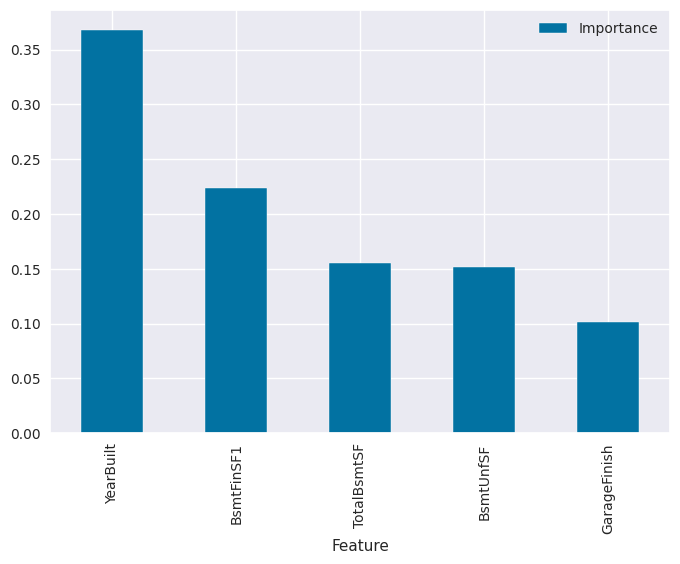

In [27]:
# after data cleaning and feature engineering, the feature space changes
# This pipeline has two data cleaning and feature engineering steps 

data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

The best_features are listed below and are stored in the variable *best_features_pipeline_all_variables*

In [28]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageFinish']

### Cluster Analysis
Load function that plots a table with description for all Clusters

In [29]:
def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = pd.concat([DescriptionAllClusters, ClusterDescription])

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription

Load custom function to plot cluster distribution per Variable 

In [30]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.histogram(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='colab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .unstack()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .stack()
                   .reset_index(name='Relative Percentage (%)')
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='colab')

Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.

In [31]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(292, 6)


,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtUnfSF,GarageFinish,Clusters
0,2002,932,1065,133,Fin,1
1,1940,399,883,484,Unf,0
2,1977,532,1040,364,Unf,0


We want also to analyse SalePrices.

In [32]:
df_SP = pd.read_csv("outputs/datasets/collection/house-price-2021.csv").filter(['SalePrice'])
df_SP['SalePrice'] = df_SP['SalePrice'] 
df_SP.head(3)

,SalePrice
0,255000
1,145000
2,150500


#### Cluster profile based on the best features

This represents the range of values for various features within each cluster, including the years built, basement finished square footage, unfinished square footage, total basement square footage, garage finish type distribution (RFn, Unf, Fin), and sale prices, with corresponding percentages for each category.

**Cluster 0:** represents houses between 1976 - 2005, with basement finished square footage ranging from 0.0 to 528.0, unfinished square footage ranging from 474.0 to 1252.0, total basement square footage ranging from 840.0 to 1405.0, a garage finish distribution of 'RFn': 54%, 'Unf': 28%, and 'Fin': 18%. Finally Sale prices fall between 160000.0 and 214000.0.

**Cluster 1:** Has houses between 1996 - 2006, with basement finished square footage ranging from 759.0 to 1218.0, unfinished square footage ranging from 116.0 to 438.0, total basement square footage ranging from 1054.0 to 1639.0, a garage finish distribution of 'Fin': 68%, 'Unf': 24%, and 'RFn': 8%. Finally Sale prices fall between 195575.0 and 301875.0.

**Cluster 2:** showcases properties between 1922 - 1965, with basement finished square footage ranging from 0.0 to 539.0, unfinished square footage ranging from 168.0 to 684.0, total basement square footage ranging from 684.0 to 1003.0, a garage finish distribution of 'Unf': 70%, 'None': 11%, and 'Fin': 10%. Finally Sale prices fall between 110500.0 and 155000.0. 

In [33]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile, df_SP], axis=1), decimal_points=0)
clusters_profile

,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtUnfSF,GarageFinish,SalePrice
Cluster,,,,,,
0,1923.0 -- 1964.0,0.0 -- 540.0,686.0 -- 995.0,166.0 -- 684.0,"'Unf': 69% , 'None': 11% , 'Fin': 10%",110000.0 -- 151350.0
1,1996.0 -- 2005.0,777.0 -- 1216.0,1038.0 -- 1622.0,113.0 -- 436.0,"'Fin': 69% , 'Unf': 25% , 'RFn': 6%",191500.0 -- 305375.0
2,1976.0 -- 2005.0,0.0 -- 529.0,848.0 -- 1420.0,461.0 -- 1254.0,"'RFn': 54% , 'Unf': 28% , 'Fin': 18%",164988.0 -- 220250.0


In [34]:
# Display the first few rows of df_cluster_profile
print("First few rows of df_cluster_profile:")
print(df_cluster_profile.head())

# Display the shape of df_cluster_profile (number of rows and columns)
print("\nShape of df_cluster_profile:")
print(df_cluster_profile.shape)

# Display information about df_cluster_profile, including data types and missing values
print("\nInformation about df_cluster_profile:")
print(df_cluster_profile.info())

# Display summary statistics for numeric columns in df_cluster_profile
print("\nSummary statistics for df_cluster_profile:")
print(df_cluster_profile.describe())

# Repeat the above steps for df_SP
print("\nFirst few rows of df_SP:")
print(df_SP.head())

print("\nShape of df_SP:")
print(df_SP.shape)

print("\nInformation about df_SP:")
print(df_SP.info())

print("\nSummary statistics for df_SP:")
print(df_SP.describe())


First few rows of df_cluster_profile:
   YearBuilt  BsmtFinSF1  TotalBsmtSF  BsmtUnfSF GarageFinish  Clusters
0       2002         932         1065        133          Fin         1
1       1940         399          883        484          Unf         0
2       1977         532         1040        364          Unf         0
3       2003        1016         1572        556          Fin         1
4       2009        1436         2006        570          Fin         1

Shape of df_cluster_profile:
(292, 6)

Information about df_cluster_profile:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   YearBuilt     292 non-null    int64 
 1   BsmtFinSF1    292 non-null    int64 
 2   TotalBsmtSF   292 non-null    int64 
 3   BsmtUnfSF     292 non-null    int64 
 4   GarageFinish  292 non-null    object
 5   Clusters      292 non-null    int32 
dtypes: int3

#### Clusters distribution across Churn levels & Relative Percentage of SalePrice in each cluster

In [35]:
df_cluster_vs_SP = df_SP.copy()
df_cluster_vs_SP['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_SP, target='SalePrice')

Clusters distribution across SalePrice levels


/tmp/ipykernel_14928/597586036.py:28: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



Relative Percentage (%) of SalePrice in each cluster


## Fit New Cluster Pipeline with most important features
In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline using the variables that are most important to define the clusters from the previous pipeline

In [36]:
best_features_pipeline_all_variables

['YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageFinish']

### Define trade-off and metrics to compare new and previous Cluster Pipeline
To evaluate this trade-off we will

1. Conduct a elbow method and silhouette analysis and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. ompare if the cluster profile from both pipelines are "equivalent"

If we are happy to say **yes** for them, we can use a cluster pipeline using the features that best define the clusters from previous pipeline!

* The **gain** is that in real-time (which is the major purpose of Machine Learning) you will need fewer variables for predicting clusters for your prospects.

### Subset data with the most relevant variables

In [37]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtUnfSF,GarageFinish
0,2002,932,1065,133,Fin
1,1940,399,883,484,Unf
2,1977,532,1040,364,Unf


Rewrite Cluster Pipeline

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

def PipelineCluster():
    # Define numerical and categorical features
    numerical_features = ['YearBuilt', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF'] 
    categorical_features = ['GarageFinish']  

    # Define transformers for numerical and categorical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combine numerical and categorical transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numeric_transformer, numerical_features),
            ('categorical', categorical_transformer, categorical_features)])

    # Define KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=0)

    # Define pipeline steps
    pipeline_base = Pipeline([
        ('preprocessor', preprocessor),
        ('model', kmeans)
    ])
    
    return pipeline_base

# Create the pipeline
pipeline = PipelineCluster()

# Display the pipeline
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearBuilt', 'BsmtFinSF1',
                                                   'BsmtUnfSF',
                                                   'TotalBsmtSF']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GarageFinish'])])),
                ('model', KMeans(n_clusters=3, random_state=0))])

### Apply Elbow Method and Silhouette analysis

In [39]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

(292, 8) 
 <class 'numpy.ndarray'>


Elbow Analysis

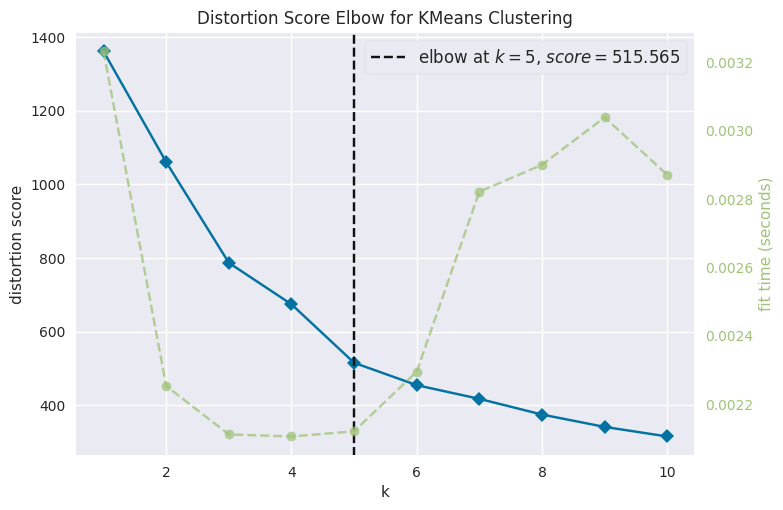

In [40]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

This code visualizes the silhouette scores and plots for different numbers of clusters to aid in selecting the optimal number of clusters for KMeans clustering.

=== Average Silhouette Score for different number of clusters ===


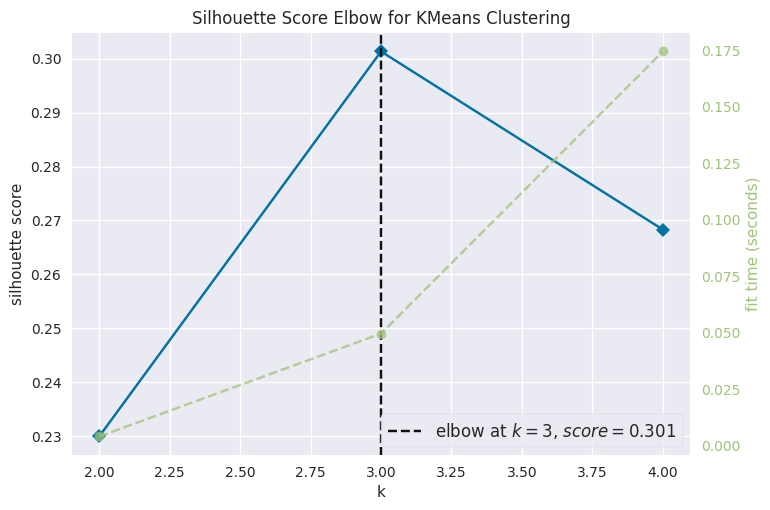



=== Silhouette plot for 2 Clusters ===


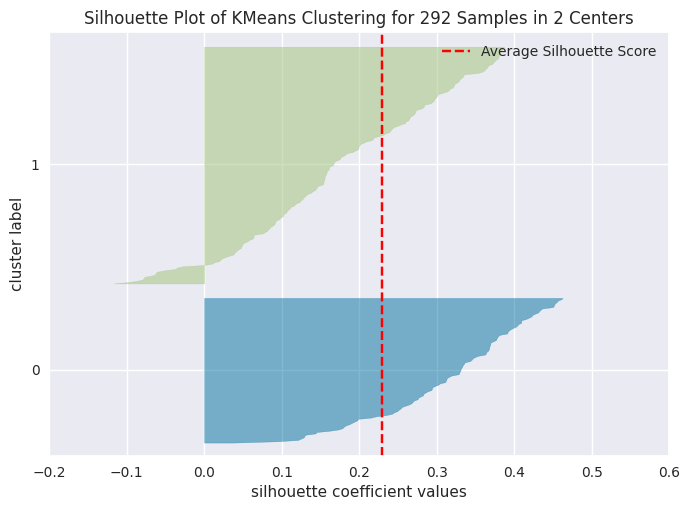



=== Silhouette plot for 3 Clusters ===


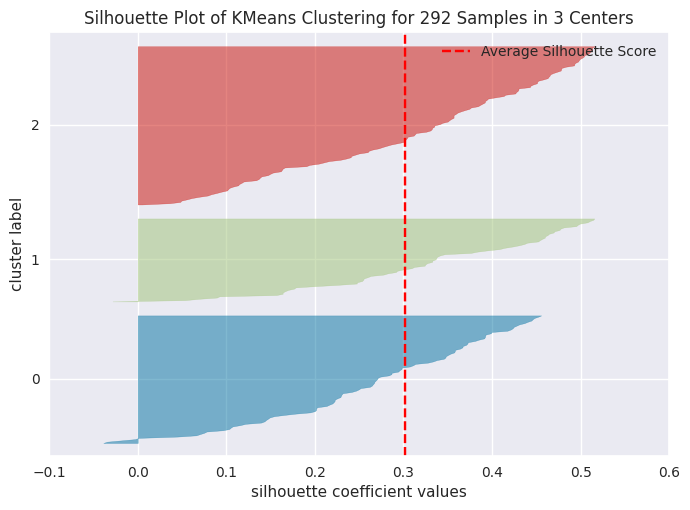



=== Silhouette plot for 4 Clusters ===


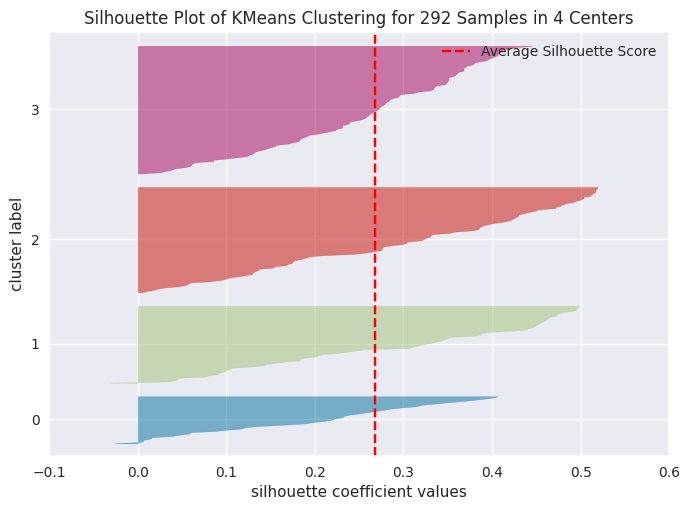

In [41]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 5

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

### Fit New Cluster Pipeline
We set X as our training set for the cluster. It is a copy of df_reduced

In [42]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

(292, 5)


,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtUnfSF,GarageFinish
0,2002,932,1065,133,Fin
1,1940,399,883,484,Unf
2,1977,532,1040,364,Unf


Fit Cluster pipeline

In [43]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearBuilt', 'BsmtFinSF1',
                                                   'BsmtUnfSF',
                                                   'TotalBsmtSF']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GarageFinish'])])),
                ('model', KMeans(n_clusters=3, random_state=0))])

### Add cluster predictions to dataset
We add a column "*Clusters*" (with the cluster pipeline predictions) to the dataset

In [44]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(292, 6)


,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtUnfSF,GarageFinish,Clusters
0,2002,932,1065,133,Fin,0
1,1940,399,883,484,Unf,2
2,1977,532,1040,364,Unf,0


* Clusters frequencies 
   Clusters
2      0.43
0      0.35
1      0.23 




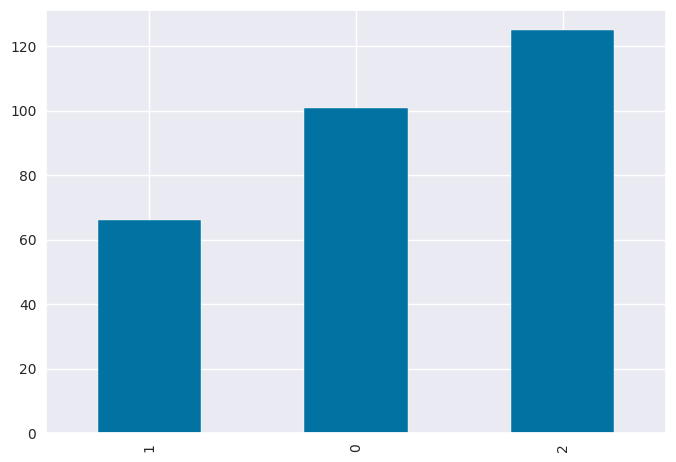

In [45]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

### Compare current cluster predictions to previous cluster predictions
We just fitted a new cluster pipeline and want to compare if its predictions are "*equivalent*" to the previous cluster.

These are the predictions from the **previous** cluster pipeline - trained with all variables

In [46]:
cluster_predictions_with_all_variables

0      1
1      0
2      0
3      1
4      1
      ..
287    0
288    1
289    1
290    1
291    2
Name: Clusters, Length: 292, dtype: int32

And these are the predictions from **current** cluster pipeline (trained with ['OnlineBackup', 'MonthlyCharges', 'PhoneService'])

In [47]:
cluster_predictions_with_best_features = X['Clusters'] 
cluster_predictions_with_best_features

0      0
1      2
2      0
3      0
4      0
      ..
287    0
288    0
289    0
290    0
291    2
Name: Clusters, Length: 292, dtype: int32

We use a confusion matrix to evaluate if the predictions of both pipelines are "**equivalent**"

In [48]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features))

[[ 23   5 112]
 [ 47   1   0]
 [ 31  60  13]]


### Fit a classifier, where the target is cluster predictions and features remaining variables

In [49]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(292, 6)


,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtUnfSF,GarageFinish,Clusters
0,2002,932,1065,133,Fin,0
1,1940,399,883,484,Unf,2
2,1977,532,1040,364,Unf,0


Split Train and Test sets

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=101
)

print(X_train.shape, X_test.shape)
df_clf.columns

(233, 5) (59, 5)


Index(['YearBuilt', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageFinish',
       'Clusters'],
      dtype='object')

Rewrite pipeline to explain clusters

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier

def PipelineClf2ExplainClusters():
    # Define categorical features
    categorical_features = ['GarageFinish']

    # Define transformers for categorical features
    categorical_transformer = OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=-1)

    # Define scaler for numerical features
    scaler = StandardScaler()

    # Define GradientBoostingClassifier
    classifier = GradientBoostingClassifier(random_state=101)

    # Define pipeline steps
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", categorical_transformer),
        ("scaler", scaler),
        ("model", classifier)
    ])
    
    return pipeline_base

# Test the pipeline
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=101))])

### Fit a classifier, where the target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [52]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=101))])

Evaluate classifier performance on Train and Test Sets

In [53]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00       105

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



In [54]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17        22
           1       0.50      0.65      0.56        17
           2       0.57      1.00      0.73        20

    accuracy                           0.56        59
   macro avg       0.69      0.58      0.49        59
weighted avg       0.71      0.56      0.47        59



### Assess Most Important Features

* These are the 5 most important features in descending order. The model was trained on them: 
['YearBuilt', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageFinish']


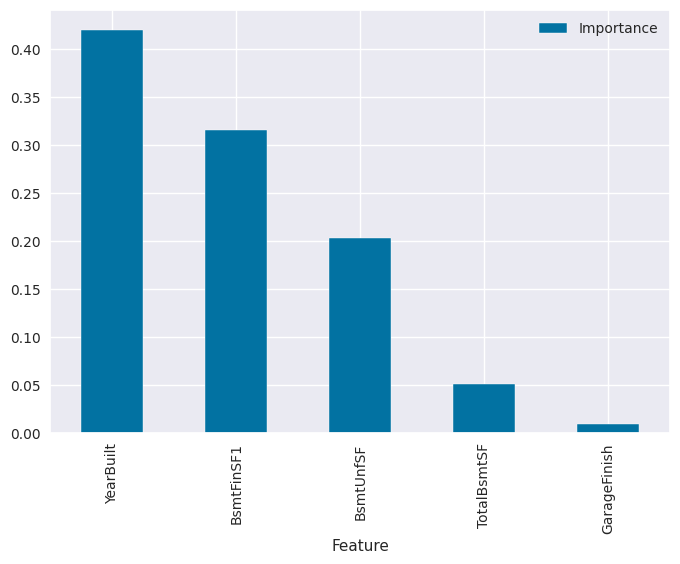

In [55]:
# since we don't have feature selection step in this pipeline, best_features is X_train columns
best_features = X_train.columns.to_list()

# create a DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Cluster Analysis
Create a DataFrame that contains the best features and Clusters Predictions: we want to analyse the patterns for each cluster.

In [56]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

,YearBuilt,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageFinish,Clusters
0,2002,932,133,1065,Fin,0
1,1940,399,484,883,Unf,2
2,1977,532,364,1040,Unf,0


We want also to analyse SalePrice levels

In [57]:
df_SP = pd.read_csv("outputs/datasets/collection/house-price-2021.csv").filter(['SalePrice'])
df_SP['SalePrice'] = df_SP['SalePrice']
df_SP.head(3)

,SalePrice
0,255000
1,145000
2,150500


### Cluster profile on most important features

In [58]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile, df_SP], axis=1), decimal_points=0)
clusters_profile

,YearBuilt,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageFinish,SalePrice
Cluster,,,,,,
0,1977.0 -- 2004.0,646.0 -- 1070.0,130.0 -- 424.0,894.0 -- 1473.0,"'Fin': 38% , 'RFn': 35% , 'Unf': 27%",157000.0 -- 256000.0
1,1992.0 -- 2005.0,0.0 -- 0.0,855.0 -- 1386.0,870.0 -- 1512.0,"'RFn': 44% , 'Fin': 29% , 'Unf': 26%",172009.0 -- 218834.0
2,1922.0 -- 1958.0,0.0 -- 428.0,264.0 -- 697.0,660.0 -- 979.0,"'Unf': 75% , 'None': 10% , 'Fin': 7%",107500.0 -- 153900.0


---

### Clusters distribution across SalePrice levels & Relative Percentage of SalePrice in each cluster

Clusters distribution across SalePrice levels


Relative Percentage (%) of SalePrice in each cluster


/tmp/ipykernel_14928/597586036.py:28: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



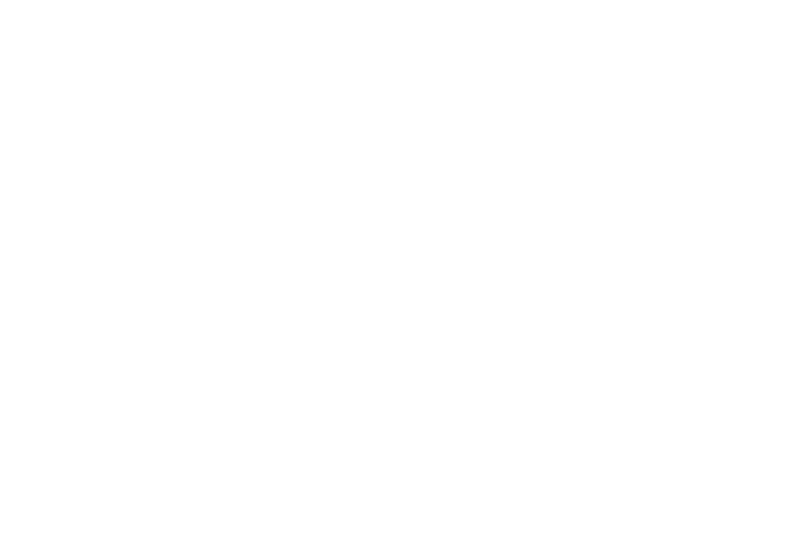

<Figure size 800x550 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Generate the plot
df_cluster_vs_SP = df_SP.copy()
df_cluster_vs_SP['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_SP, target='SalePrice')

# Save the plot to a file
plt.savefig('cluster_distribution.png')

# Display the saved image
Image(filename='cluster_distribution.png')
image_path = 'cluster_distribution.png'
display(Image(filename=image_path))


In [60]:
pipeline_cluster

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearBuilt', 'BsmtFinSF1',
                                                   'BsmtUnfSF',
                                                   'TotalBsmtSF']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GarageFinish'])])),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Push files to Repo
We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette

In [61]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/cluster_analysis/v1'


### Cluster pipeline

In [62]:
pipeline_cluster

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['YearBuilt', 'BsmtFinSF1',
                                                   'BsmtUnfSF',
                                                   'TotalBsmtSF']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GarageFinish'])])),
                ('model', KMeans(n_clusters=3, random_state=0))])

In [63]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

['outputs/ml_pipeline/cluster_analysis/v1/cluster_pipeline.pkl']

## Train Set

In [64]:
print(df_reduced.shape)
df_reduced.head(3)

(292, 5)


,YearBuilt,BsmtFinSF1,TotalBsmtSF,BsmtUnfSF,GarageFinish
0,2002,932,1065,133,Fin
1,1940,399,883,484,Unf
2,1977,532,1040,364,Unf


In [65]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot
These are the features that define a cluster

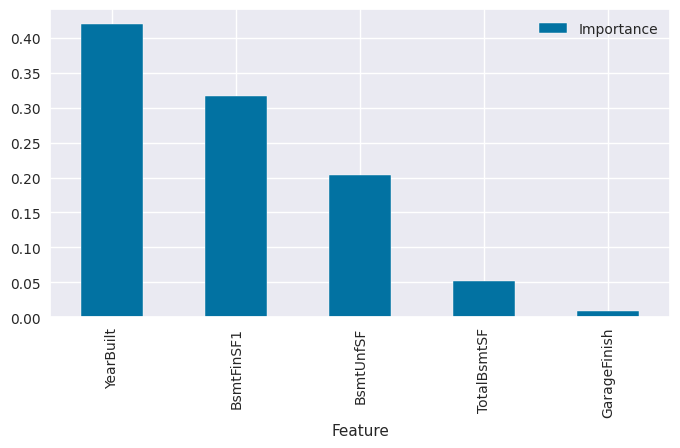

In [66]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance', figsize=(8,4))
plt.show()

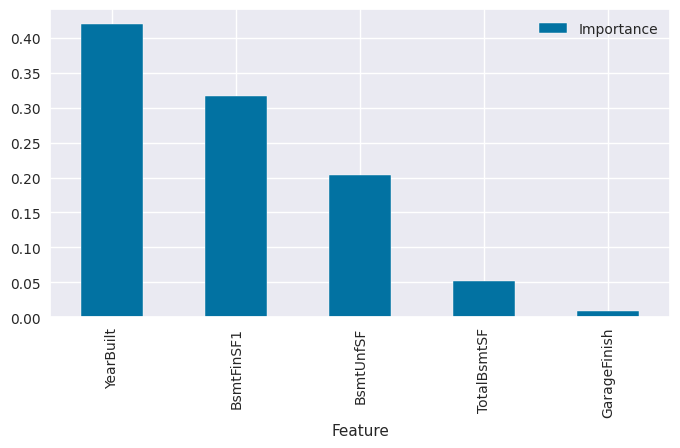

In [67]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [68]:
clusters_profile

,YearBuilt,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageFinish,SalePrice
Cluster,,,,,,
0,1977.0 -- 2004.0,646.0 -- 1070.0,130.0 -- 424.0,894.0 -- 1473.0,"'Fin': 38% , 'RFn': 35% , 'Unf': 27%",157000.0 -- 256000.0
1,1992.0 -- 2005.0,0.0 -- 0.0,855.0 -- 1386.0,870.0 -- 1512.0,"'RFn': 44% , 'Fin': 29% , 'Unf': 26%",172009.0 -- 218834.0
2,1922.0 -- 1958.0,0.0 -- 428.0,264.0 -- 697.0,660.0 -- 979.0,"'Unf': 75% , 'None': 10% , 'Fin': 7%",107500.0 -- 153900.0


In [69]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

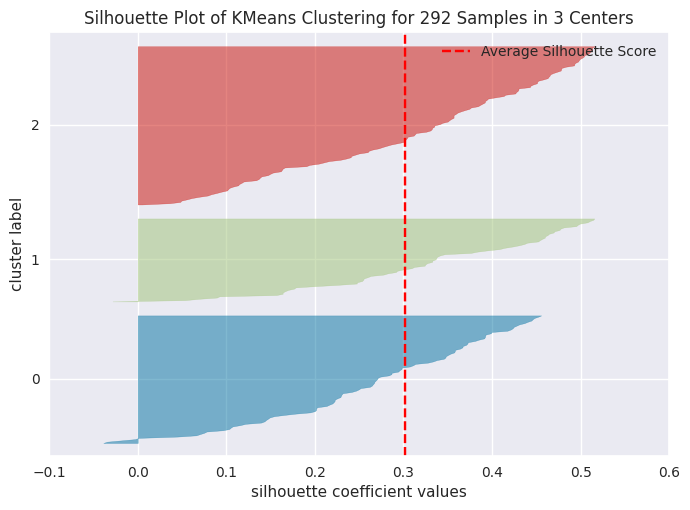

In [70]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0], colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

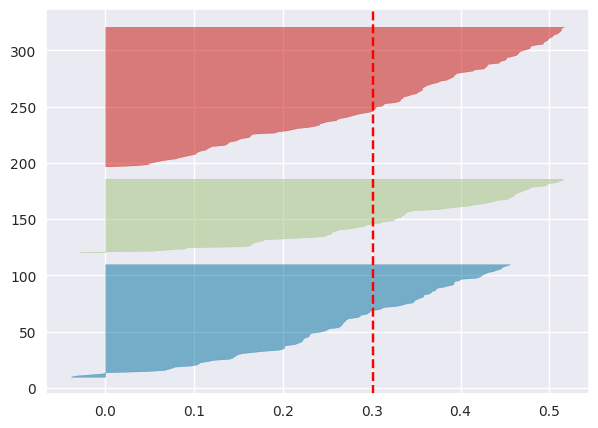

In [71]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0], colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight', dpi=150)